# Abstract

Stock prediction is always a hot topic as everyone wants to win money from the stock market and stock forecasting models have important value in the field of quantitative finance. 

Nowadays, people begin to dine useful information for stock trading or prediction from all kinds of big data with big data analytics tools, machine learning methods or even deep learning. In our project, we build models for stock movement and stock price prediction with features including financial indicators and sentimental analysis from social networks. 

First, we implement NLP models for text analysis on Tweets and headlines related to the companies listed in the datasets. With sentimental analysis, we analyze the correlations between news and market trends. 

Second, some basic analysis is applied to the financial data. In this part, we analyze development of different sectors, correlation between different sectors and correlation between different financial indicators, which helps to select features for machine learning. 

Finally, three types of machine learning models are built for stock trend prediction, including Random Forest, SVM and Logistic Regression.

# Hyperlink

In addition to view this notebook file, you can access the project via Github or personal websites

* [Github](https://github.com/MCChang1117/upenn-CIS545-Final-Project)
* [Personal Blog](https://mcchanglife.com/project-upenn-cis-545/)

# Part 0: Libraries Set Up and Access Dataset

### Download Dataset

All datasets we used are downloaded via Kaggle. In this block, we would show where to download our datasets

#### Data Source

##### Text Analysis

1. [Tweets about the Top Companies from 2015 to 2020 | Kaggle](https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020)

2. [Top Tech Companies Stock Price](https://www.kaggle.com/tomasmantero/top-tech-companies-stock-price)

3. [News Category Dataset | Kaggle](https://www.kaggle.com/rmisra/news-category-dataset)

##### Financial Data Analysis

1. [Historical Financials Data for 3000+ stocks](https://www.kaggle.com/miguelaenlle/parsed-sec-10q-filings-since-2006)

2. [US historical stock prices with earnings data](https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data?select=stocks_latest)

3. [200+ Financial Indicators of US stocks (2014-2018)](https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018)

#### Collecting Data

We imported the following files to different pandas dataframes

##### Text Analysis

| Variable Name            | File Name                     |
|--------------------------|-------------------------------|
|tweet_df                  | [Tweet.csv](https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020?select=Tweet.csv) |
|tweet_company_relation_df | [Company_Tweet.csv](https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020?select=Company_Tweet.csv) |
|tweet_company_symbol_df   | [Company.csv](https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020?select=Company.csv) |
|news_df                   | [News_Category_Dataset_v2.json](https://www.kaggle.com/rmisra/news-category-dataset?select=News_Category_Dataset_v2.json) |
|company_ticker_relation_df| [company_sector.csv](https://www.kaggle.com/tomasmantero/top-tech-companies-stock-price?select=List+of+SP+500+companies.csv) |

##### Financial Data Analysis

| Variable Name     | File Name                |
|-------------------|--------------------------|
|raw_feature_df     | [quarterly_financials.csv](https://www.kaggle.com/miguelaenlle/parsed-sec-10q-filings-since-2006?select=quarterly_financials.csv) |
|price_df           | [stock_prices_latest.csv](https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data) |
|sector_relation_df | [2016_Financial_Data.csv](https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018?select=2016_Financial_Data.csv)  |


### Python Libraries

Firstly, install and import python related libraries

In [18]:
!pip install pandasql
!pip install wordcloud

In [19]:
import pandas as pd
import pandasql as ps
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from string import ascii_letters
import re
import wordcloud
from collections import Counter
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Dataset

Then load and acceess the data stored in google drive

* Financial feature dataset 
* Historical stock price dataset 
* Sector mapping dataset

In [20]:
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/CIS545_Final_Project/dataset

# Text Analysis

tweet_df                  = pd.read_csv('text/tweet/Tweet.csv')
tweet_company_relation_df = pd.read_csv('text/tweet/Company_Tweet.csv')
tweet_company_symbol_df   = pd.read_csv('text/tweet/Company.csv')
news_df                   = pd.read_json('text/News_Category_Dataset_v2.json', lines=True)
company_ticker_relation_df = pd.read_csv('text/company_sector.csv')

# Financial Data Analysis

raw_feature_df      = pd.read_csv("financial/quarterly_financials.csv")
price_df            = pd.read_csv('financial/stock_prices_latest.csv')
sector_relation_df  = pd.read_csv('financial/2016_Financial_Data.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/CIS545_Final_Project/dataset


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Part 1: Text Analysis

In the first part, we would analyze the following two datasets

* Headline and short description of the news
* Tweet comments among 5 tech companies


### 1.1 News Dataset

#### 1.1.1 Ticker Symbol Relation Dataframe and Dictionary

We would use the company name in the dataset (SP 500) as the keyword to search the texts in news dataset

However, we need to clean the text of company name first to make sure that we can match the searching result. For example

* AbbVie Inc. > AbbVie
* Amazon.com > Amazon

Thus, we would use regular expression and manual adjustment to clean the dataset of ticker symbol-company name

In [21]:
# Remove redundant words with regex
company_ticker_relation_df['Name'].replace(to_replace=r'\W+\(.+?\)\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+Inc\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+[Pp][Ll][Cc]\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+[Ll][Tt][Dd]\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+Corp\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+Company\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+Co\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\.com$', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+Group\W*', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\W+Int\'l', value='', regex=True, inplace=True)
company_ticker_relation_df['Name'].replace(to_replace=r'\'s', value='', regex=True, inplace=True)

# Convert dataframe to dictionary
ticker_dict = company_ticker_relation_df.set_index('Symbol')['Name'].to_dict()

# Manually adjustment
ticker_dict['GOOG'] = 'Google'
ticker_dict['MMM'] = ' 3M '
ticker_dict['KO'] = 'Cola'
ticker_dict['QCOM'] = 'Qualcomm'
del ticker_dict['GOOGL']

# Extract company name and ticker symbol as lists
companies_list = list(ticker_dict.values())
companies_ticker_list = list(ticker_dict.keys())

In [22]:
company_ticker_relation_df

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A.O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,ABIOMED,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet Holdings,Health Care
503,ZION,Zions Bancorp,Financials


Make stock-sector mapping dataset, named sector_relation_df to divide each company to corresponding industries.

In [23]:
sector_relation_df = sector_relation_df[['Unnamed: 0', 'Sector']].rename(columns={'Unnamed: 0': 'stock'})

In [24]:
sector_relation_df

,stock,Sector
0,PG,Consumer Defensive
1,VIPS,Consumer Defensive
2,KR,Consumer Defensive
3,RAD,Consumer Defensive
4,GIS,Consumer Defensive
...,...,...
4792,TSRI,Technology
4793,TZOO,Technology
4794,USATP,Technology
4795,WSTG,Technology


#### 1.1.2 News - Company Mapping

We would use the result in 1.1.1 to assign the company name and its ticker symbol to the rows that containing the keywords (company name)

The news dataframe have two related text fields: ``headline`` and ``short_description``. We would assign the company name either headline or short description has the matched substring

In [25]:
news_12_18_companies_df = pd.DataFrame(columns=['date', 'headline', 'short_description', 'company'])
news_company_count_df = pd.DataFrame(columns=['company', 'count'])
news_company_count_dict = {}

for idx, (company, symbol) in enumerate(zip(companies_list, companies_ticker_list)):
    temp_df = news_df[news_df['headline'].str.contains(company) | news_df['short_description'].str.contains(company)]
    news_count = temp_df.shape[0]

    print('Progress (' + str(idx+1) + '/' + str(len(companies_list)) + '): ' + company + ' > ' + str(news_count))
    temp_df['company'] = company
    temp_df['symbol'] = symbol
    news_12_18_companies_df = news_12_18_companies_df.append(temp_df, ignore_index=True)
    if news_count > 0:
        news_company_count_dict[company] = news_company_count_dict.get(company, 0) + news_count

for company, count in news_company_count_dict.items():
    news_company_count_df = news_company_count_df.append({'company': company, 'count': count}, ignore_index=True)

Progress (1/504):  3M  > 0
Progress (2/504): A.O. Smith > 0
Progress (3/504): Abbott Laboratories > 0
Progress (4/504): AbbVie > 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Progress (5/504): ABIOMED > 0
Progress (6/504): Accenture > 3
Progress (7/504): Activision Blizzard > 1
Progress (8/504): Adobe > 9
Progress (9/504): Advance Auto Parts > 0
Progress (10/504): Advanced Micro Devices > 0
Progress (11/504): AES > 0
Progress (12/504): AFLAC > 0
Progress (13/504): Agilent Technologies > 0
Progress (14/504): Air Products & Chemicals > 0
Progress (15/504): Akamai Technologies > 0
Progress (16/504): Alaska Air > 11
Progress (17/504): Albemarle > 0
Progress (18/504): Alexandria Real Estate Equities > 0
Progress (19/504): Alexion Pharmaceuticals > 0
Progress (20/504): Align Technology > 0
Progress (21/504): Allegion > 0
Progress (22/504): Alliant Energy > 0
Progress (23/504): Allstate > 7
Progress (24/504): Google > 522
Progress (25/504): Altria > 1
Progress (26/504): Amazon > 324
Progress (27/504): Amcor > 0
Progress (28/504): Ameren > 0
Progress (29/504): American Airlines > 57
Progress (30/504): American Electric Power > 0
Progress (31/504): American Express 

Here, we draw a bar plot to see the distribution of the number of news for those top 30 companies

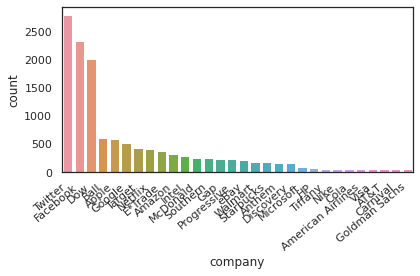

In [26]:
news_company_count_df = news_company_count_df.sort_values(by=['count'], ascending=[False])
news_company_count_df = news_company_count_df.head(30)
news_company_count_barplot = sns.barplot(x='company', y='count', data=news_company_count_df, ci=None)
news_company_count_barplot.set_xticklabels(labels=news_company_count_barplot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We find that only the number of top 3 companies are far more than the rest, and most of news are related to technology.

Therefore, we analyze tweets only related to 5 top tech companies to refine our result

#### 1.1.3 Sentiment Analysis

We would implement sentiment analysis to compute the compound score of every sentence. 

The compound score ranges from -1 (negative) to 1 (positive).

In [27]:
def sentimentAnalysis(df):
    sia = nltk.sentiment.SentimentIntensityAnalyzer()
    result_headline = sia.polarity_scores(df['headline'])
    result_body = sia.polarity_scores(df['short_description'])
    df['headline_neg'] = result_headline['neg']
    df['headline_neu'] = result_headline['neu']
    df['headline_pos'] = result_headline['pos']
    df['headline_compound'] = result_headline['compound']
    df['body_neg'] = result_body['neg']
    df['body_neu'] = result_body['neu']
    df['body_pos'] = result_body['pos']
    df['body_compound'] = result_body['compound']
    return df

news_12_18_companies_df = news_12_18_companies_df.apply(sentimentAnalysis, axis=1)
news_12_18_companies_compound_df = news_12_18_companies_df[['date', 'company', 'headline_compound', 'body_compound', 'symbol']].groupby(['date', 'company', 'symbol']).sum().reset_index()

news_compound_sector_query = '''
SELECT news.date, news.company, news.symbol, news.headline_compound, news.body_compound, sector.Sector AS sector
  FROM news_12_18_companies_compound_df AS news
JOIN sector_relation_df AS sector
  ON news.symbol = sector.stock
'''

news_12_18_companies_compound_df = ps.sqldf(news_compound_sector_query)

In [28]:
news_12_18_companies_compound_df

,date,company,symbol,headline_compound,body_compound,sector
0,2012-01-28 00:00:00.000000,AT&T,T,0.0000,0.3612,Communication Services
1,2012-01-28 00:00:00.000000,Adobe,ADBE,0.5574,0.0000,Technology
2,2012-01-28 00:00:00.000000,American International,AIG,0.0000,0.0000,Financial Services
3,2012-01-28 00:00:00.000000,Apple,AAPL,0.0000,-0.4215,Technology
4,2012-01-28 00:00:00.000000,Cola,KO,0.2732,0.6956,Consumer Defensive
...,...,...,...,...,...,...
8543,2018-05-25 00:00:00.000000,Twitter,TWTR,0.1027,0.5106,Technology
8544,2018-05-25 00:00:00.000000,Visa,V,-0.4767,-0.4767,Financial Services
8545,2018-05-26 00:00:00.000000,Amazon,AMZN,0.1779,0.6249,Technology
8546,2018-05-26 00:00:00.000000,McDonald,MCD,0.0000,0.0000,Consumer Cyclical


#### 1.1.4 Wordcloud

We would draw the wordcloud and word frequencies bar plot with the following steps

1. Clean the texts
2. Tokenize the texts
3. Concatenate the words
4. Plot the wordCloud

In [29]:
def tokenized_content(content, companies):
  result = []
  companies_lower = set([name.lower() for name in companies])
  for single in content:
    for w in nltk.word_tokenize(single):
      w = w.lower()
      if w in companies_lower:
        continue
      if w not in stopwords and w.isalpha():
        result.append(w)

  return result

In [30]:
def draw_words_barplot_from_list(x_list, y_list, title):

    words_top_df = pd.DataFrame(list(zip(x_list, y_list)), columns =['word', 'count'])
    words_top_df = words_top_df.sort_values(by=['count'], ascending=[False])
    words_top_barplot = sns.barplot(x='word', y='count', data=words_top_df, ci=None)
    words_top_barplot.set_xticklabels(labels=words_top_barplot.get_xticklabels(), rotation=40, ha="right")
    plt.title(title, fontsize=30)
    plt.tight_layout()
    plt.show()

In [31]:
def draw_wordcloud(df, col, companies, plot_title):
    plot_title = "Sector: " + plot_title

    # Convert dataframe to list
    contents = df[col].values.tolist()

    # Tokenize the contents (and filter the names of companies)
    contents_tokens = tokenized_content(contents, companies)
    contents_most_common_count = Counter(contents_tokens)

    # Draw the barplot of word frequencies
    words_top = []
    words_top_count = []
    contents_words_top = contents_most_common_count.most_common(10)
    for (word, count) in contents_words_top:
        words_top.append(word)
        words_top_count.append(count)
    draw_words_barplot_from_list(words_top, words_top_count, plot_title)

    # Concatenate words in contents
    contents_word_cloud = ""
    contents_words = [w[0] for w in contents_most_common_count.most_common()]
    contents_word_cloud += " ".join(contents_words) + ""

    # Plot the wordcloud
    word_cloud = wordcloud.WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(contents_word_cloud)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title(plot_title, fontsize=30)
    plt.tight_layout(pad = 0)
    
    plt.show()

In [32]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
COMMON_WORD_COUNT = 20

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
news_12_18_companies_text_df = news_12_18_companies_df[['company', 'headline', 'short_description', 'symbol']]

# Add sector to dataframe
news_text_sector_query = '''
SELECT news.company, news.symbol, news.headline, news.short_description, sector.Sector AS sector
  FROM news_12_18_companies_df AS news
JOIN sector_relation_df AS sector
  ON news.symbol = sector.stock
'''

news_12_18_companies_text_df = ps.sqldf(news_text_sector_query)

##### Headline / Short Description

Draw plots of all sectors in headline and short description, respectively

Headline: 


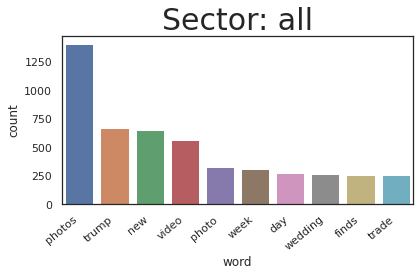

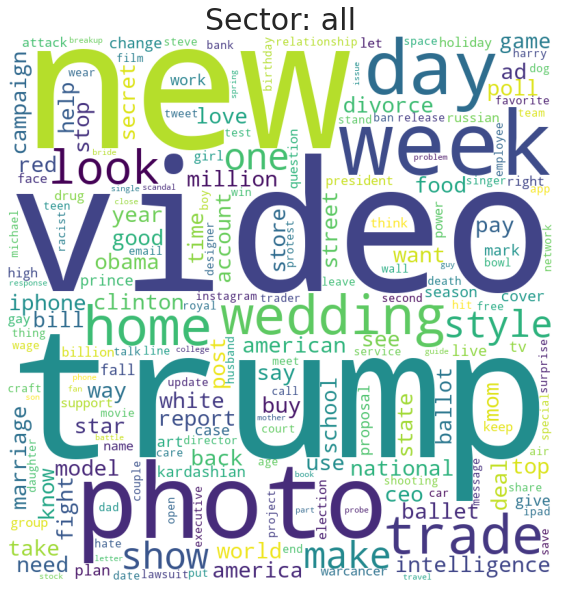

Short Description: 


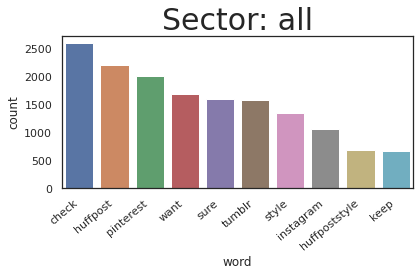

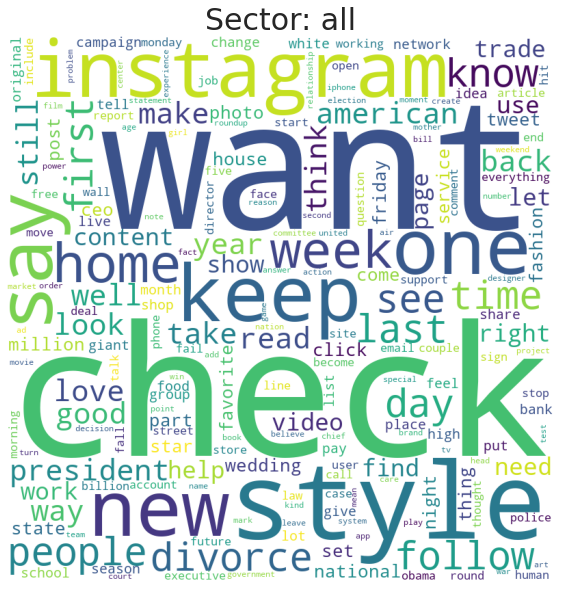

In [34]:
print('Headline: ')
draw_wordcloud(news_12_18_companies_text_df, 'headline', companies_list, 'all')
print('Short Description: ')
draw_wordcloud(news_12_18_companies_text_df, 'short_description', companies_list, 'all')

##### Sectors

For headline, we draw plots for all sectors

In [35]:
filtered_sectors = news_12_18_companies_text_df['sector'].unique()

for sector in filtered_sectors:
    news_12_18_sectors_df = news_12_18_companies_text_df[news_12_18_companies_text_df['sector'] == sector]
    draw_wordcloud(news_12_18_sectors_df, 'headline', companies_list, sector)

Output hidden; open in https://colab.research.google.com to view.

##### Conclusion

* News
  * We can see the word distribution of headline and short description are quite different
* Different Sectors
  * For most of sectors, the keyword follows its features (e.g. health care > drug)
  * For sectors have much more data, some of keywords are related to global trend (e.g. trump for technology) 


#### 1.1.5 Stock Difference Dataframe

Here, we want to see the relationship between headline compound scores (from 1.1.3) and daily stock price difference

Thus, in 1.1.5 we create the dataframe with the column indicating stock differnece

In [36]:
stock_price_df = price_df.copy()

# Remove unused columns
stock_price_df = stock_price_df[['date', 'symbol', 'close']]

# Select 500 companies
stock_price_symbol_df = stock_price_df.loc[stock_price_df['symbol'].isin(companies_ticker_list)]

# Add sector
stock_join_sector_query = '''
SELECT stock.date, stock.symbol, stock.close, sector.Sector AS sector
  FROM stock_price_symbol_df AS stock
JOIN sector_relation_df AS sector
  ON stock.symbol = sector.stock
'''
stock_price_sector_df = ps.sqldf(stock_join_sector_query)

# Convert date format
stock_price_sector_df['date'] = pd.to_datetime(stock_price_sector_df['date'])

To find the daily stock difference, we create one dataset and merge with original one

1. Copy the stock dataframe with date offset (storing the stock price of next day)
2. Merge the original stock dataframe with the offset dataframe

In [37]:
# Create offset dataframe
stock_price_sector_offset_df = stock_price_sector_df.copy()
stock_price_sector_offset_df['date'] = stock_price_sector_offset_df['date'] - pd.DateOffset(days=1)

# Merge the two dataframe
stock_diff_merge_query = '''
SELECT origin.date, (offset.close - origin.close)/origin.close AS diff, origin.symbol, origin.sector
  FROM stock_price_sector_df AS origin
JOIN stock_price_sector_offset_df AS offset
  ON origin.date = offset.date AND origin.symbol = offset.symbol
'''

stock_diff_sector_df = ps.sqldf(stock_diff_merge_query)

In [38]:
stock_diff_sector_df

,date,diff,symbol,sector
0,2016-05-16 00:00:00.000000,-0.025468,MSFT,Technology
1,2002-01-16 00:00:00.000000,0.029321,MSFT,Technology
2,2001-09-18 00:00:00.000000,-0.008284,MSFT,Technology
3,2011-12-06 00:00:00.000000,-0.002338,MSFT,Technology
4,2000-05-08 00:00:00.000000,-0.028649,MSFT,Technology
...,...,...,...,...
1979173,2021-06-09 00:00:00.000000,0.003025,GRMN,Technology
1979174,2021-06-03 00:00:00.000000,0.009985,GRMN,Technology
1979175,2021-06-07 00:00:00.000000,-0.005025,GRMN,Technology
1979176,2021-06-10 00:00:00.000000,0.015147,GRMN,Technology


#### 1.1.6 Stock Difference and Compound Score

Finally, we merge the result from 1.1.3 and 1.1.5

In [39]:
merge_news_stock_diff_query = '''
SELECT news.date, news.company, news.symbol, news.sector, news.headline_compound, news.body_compound, stock.diff AS stock_diff
  FROM news_12_18_companies_compound_df AS news
JOIN stock_diff_sector_df AS stock
  ON news.date = stock.date AND news.symbol = stock.symbol
'''
news_stock_diff_df = ps.sqldf(merge_news_stock_diff_query)

In [40]:
news_stock_diff_df

,date,company,symbol,sector,headline_compound,body_compound,stock_diff
0,2012-01-30 00:00:00.000000,Ball,BLL,Consumer Cyclical,0.3818,0.7184,0.002042
1,2012-01-30 00:00:00.000000,HP,HPQ,Technology,0.8313,0.7964,0.003587
2,2012-01-31 00:00:00.000000,eBay,EBAY,Consumer Cyclical,0.0000,0.3182,0.019149
3,2012-02-01 00:00:00.000000,Apple,AAPL,Technology,0.0000,0.0000,-0.002346
4,2012-02-01 00:00:00.000000,PepsiCo,PEP,Consumer Defensive,0.6369,0.7003,0.000301
...,...,...,...,...,...,...,...
4495,2018-05-24 00:00:00.000000,Anthem,ANTM,Healthcare,-0.9169,0.5002,0.007675
4496,2018-05-24 00:00:00.000000,Ball,BLL,Consumer Cyclical,0.0000,0.2732,0.000522
4497,2018-05-24 00:00:00.000000,Facebook,FB,Technology,-0.4767,0.2677,-0.005432
4498,2018-05-24 00:00:00.000000,Netflix,NFLX,Communication Services,0.0000,0.0000,0.005726


##### Scatter Plot (Overall)

* Drop rows with zero compound score
* Compound Score / Daily Stock Price Difference (All)
* Headline Compound Score / Body Compound Score

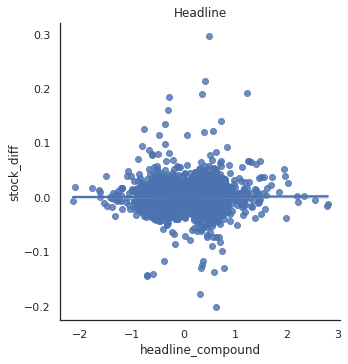

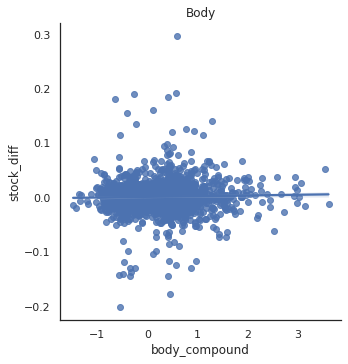

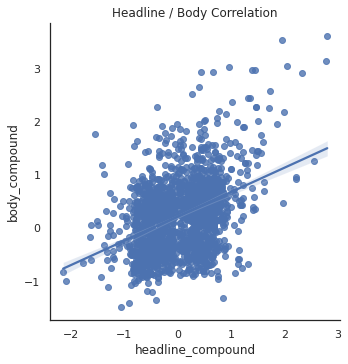

In [41]:
def draw_lmplot(df, x_col, y_col, title, hue=None):
    sns.lmplot(x=x_col, y=y_col, data=df, hue=hue, fit_reg=True) 
    ax = plt.gca()
    ax.set_title(title)

# Drop rows
news_stock_diff_headline_df = news_stock_diff_df[news_stock_diff_df['headline_compound'] != 0]
news_stock_diff_body_df = news_stock_diff_df[news_stock_diff_df['body_compound'] != 0]
news_stock_diff_nonzero_df = news_stock_diff_df[(news_stock_diff_df['headline_compound'] != 0) & (news_stock_diff_df['body_compound'] != 0)]

# Draw plots
draw_lmplot(news_stock_diff_headline_df, 'headline_compound', 'stock_diff', 'Headline')
draw_lmplot(news_stock_diff_body_df, 'body_compound', 'stock_diff', 'Body')
draw_lmplot(news_stock_diff_nonzero_df, 'headline_compound', 'body_compound', 'Headline / Body Correlation')

##### Scatter Plot (Sector)

* All sectors on the same plot
* Each sector for one plot

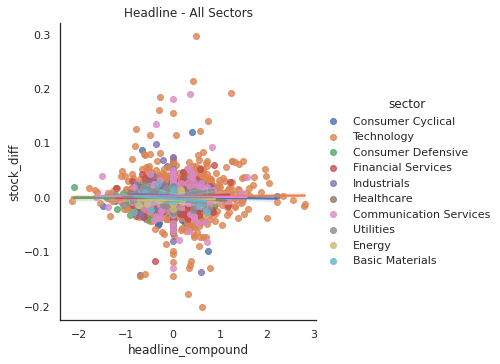

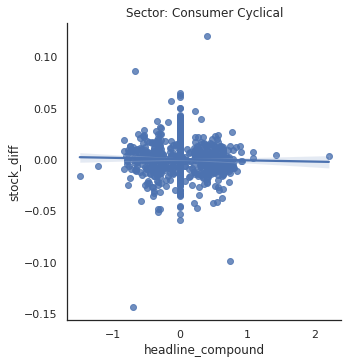

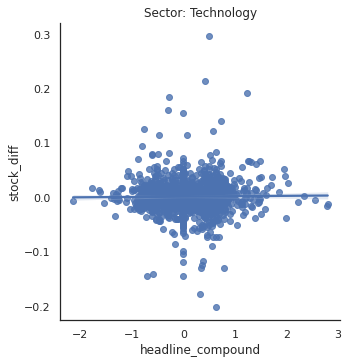

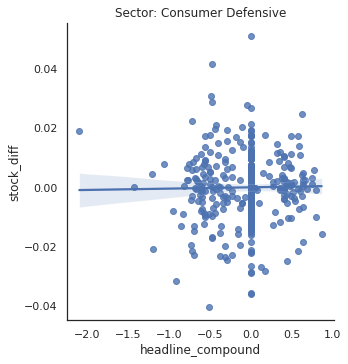

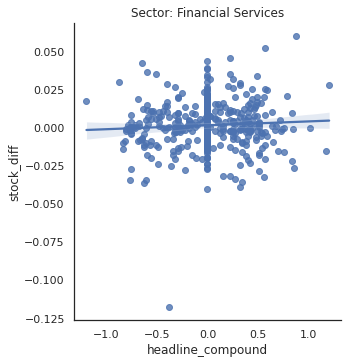

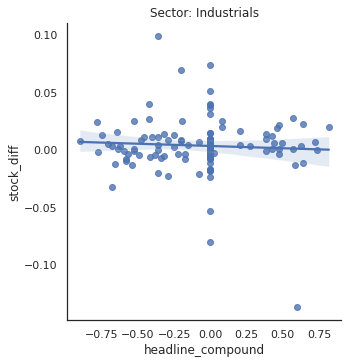

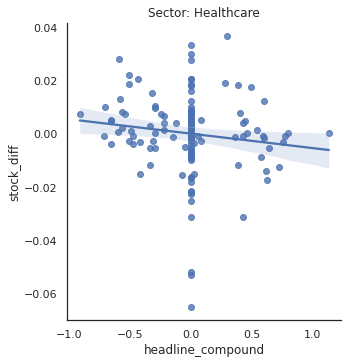

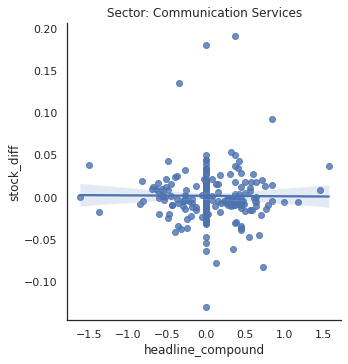

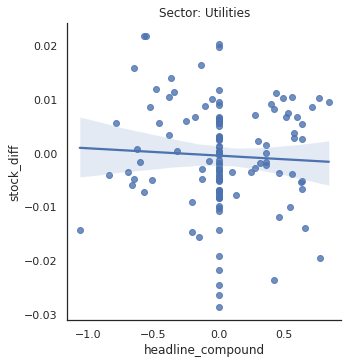

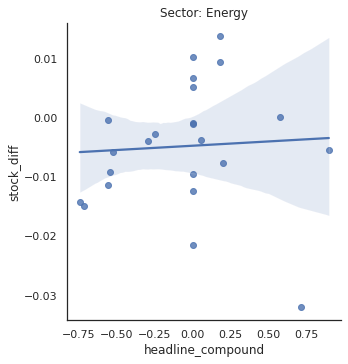

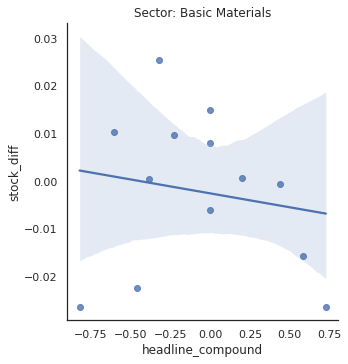

In [42]:
draw_lmplot(news_stock_diff_df, 'headline_compound', 'stock_diff', 'Headline - All Sectors', hue='sector')
sector_list = news_stock_diff_df['sector'].unique()
for sector in sector_list:
    title = 'Sector: ' + sector
    plot_sector_df = news_stock_diff_df[news_stock_diff_df['sector'] == sector]
    draw_lmplot(plot_sector_df, 'headline_compound', 'stock_diff', title)

##### Conclusion

Originally, we thought the compound scores are highly correlated to daily stock price movement. 

To our surprise, no matter how many data we have, those two variables are nearly independent and we cannot capture the trend from the scatter plots above.

#### 1.1.7 Machine Learning

Here we need to arrange the compound score dataframe for further machine learning

### Aggregation (sum)

We need to aggregate the scale from daily to quartly

### Notice

* For companies (SP 500) that do not have the score, fill the value as zero
* You can use either headline or body since those two values are correlated

In [43]:
# Year and quarter
compound_score_quarter_ml_df = news_12_18_companies_df[['date', 'symbol', 'headline_compound', 'body_compound']]
compound_score_quarter_ml_df['year'] = pd.DatetimeIndex(compound_score_quarter_ml_df['date']).year
compound_score_quarter_ml_df['quarter'] = pd.to_datetime(compound_score_quarter_ml_df['date']).dt.quarter
compound_score_quarter_ml_df = compound_score_quarter_ml_df[['symbol', 'year', 'quarter', 'headline_compound', 'body_compound']]
# Aggregate the dataframe with summation
compound_score_ml_df = compound_score_quarter_ml_df.groupby(['year', 'quarter', 'symbol']).sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
compound_score_ml_df

,year,quarter,symbol,headline_compound,body_compound
0,2012,1,AAL,-2.0227,-0.0772
1,2012,1,AAPL,-0.5629,0.4269
2,2012,1,ADBE,0.5574,0.0000
3,2012,1,AIG,0.0000,0.0000
4,2012,1,AMZN,-0.0040,2.9450
...,...,...,...,...,...
1245,2018,2,TGT,-1.8038,-0.6668
1246,2018,2,TIF,-0.5574,-0.2500
1247,2018,2,TWTR,-3.0129,-3.7042
1248,2018,2,V,-0.4767,-0.4767


### 1.2 Tweet Dataset

#### 1.2.1 Ticker Symbol Relation Dictionary

Since there are only five companies, we can just create the mapping dictionary manually

In [45]:
tweet_company_symbol_dict = {'AAPL': 'Apple',
                             'GOOG': 'Google',
                             'AMZN': 'Amazon',
                             'TSLA': 'Tesla',
                             'MSFT': 'Microsoft'}

# Extract company name and ticker symbol as lists
tweet_companies_list = list(tweet_company_symbol_dict.values())
tweet_companies_symbol_list = list(tweet_company_symbol_dict.keys())

#### 1.2.2 Data Cleaning and Wrangling

1. Thresholding (Like, Retweet, Comment): ``tweet_threshold_df``

> Since the size of tweet dataframe is far more than the news dataframe, we would use downsampling to reduce the number of rows.

2. Convert date format (from timestamp to datetime)
3. Assign company name: ``tweet_company_df``


In [46]:
# Thresholding
LIKE_THRESHOLD = 10
RETWEET_THRESHOLD = 10
COMMENT_THRESHOLD = 0

tweet_threshold_df = tweet_df[(tweet_df['like_num'] >= LIKE_THRESHOLD) & (tweet_df['retweet_num'] >= RETWEET_THRESHOLD) & (tweet_df['comment_num'] >= COMMENT_THRESHOLD)]

# Convert time format
tweet_threshold_df['post_date'] = pd.to_datetime(tweet_threshold_df['post_date'], unit='s').apply(lambda x: x.date())

# Assign company name
tweet_company_query = '''
SELECT name.company_name AS company, name.ticker_symbol AS symbol, tweet.body, tweet.post_date AS date, tweet.comment_num, tweet.retweet_num, tweet.like_num
  FROM tweet_company_relation_df AS relation
JOIN tweet_threshold_df AS tweet 
  ON relation.tweet_id = tweet.tweet_id
JOIN tweet_company_symbol_df AS name
  ON relation.ticker_symbol = name.ticker_symbol
'''

tweet_company_df = ps.sqldf(tweet_company_query)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [47]:
tweet_company_df

,company,symbol,body,date,comment_num,retweet_num,like_num
0,apple,AAPL,This is Wall Street's top pick in 2015. Hint: ...,2015-01-01,5,37,22
1,apple,AAPL,"See how tech companies like Apple, Twitter and...",2015-01-01,15,223,109
2,apple,AAPL,"Earlier this month, a mysterious glitch caused...",2015-01-01,4,18,17
3,apple,AAPL,Trading Trends for 2015 from http://PhilStockW...,2015-01-02,0,916,59
4,apple,AAPL,Check out the 100 top-performing stocks of 201...,2015-01-03,0,11,10
...,...,...,...,...,...,...,...
39068,Tesla Inc,TSLA,So apropos for Tesla to close the year at $420...,2019-12-31,14,15,316
39069,Tesla Inc,TSLA,Tesla’s Impressive Developments From 2019 Lead...,2019-12-31,1,21,96
39070,Tesla Inc,TSLA,Met one of the youngest and biggest #tesla fan...,2019-12-31,9,16,178
39071,Tesla Inc,TSLA,I have not seen a company try this hard to win...,2019-12-31,10,32,376


#### 1.2.3 Wordcloud

Here we would use the same function in 1.1.4 to draw the wordcloud.

However, since tweet contents are not as formal as news conents, we would remove some unrelated words manually

* Company names
* Ticker symbols
* http

In [48]:
# Manually tune
removal_word_list = tweet_companies_list.copy()
removal_word_list.extend(tweet_companies_symbol_list)
removal_word_list.extend(['http', 'https', 'googl', 'fb', 'tslaq', 'nflx'])

In [49]:
# Five companies together
draw_wordcloud(tweet_company_df, 'body', removal_word_list, 'all')

# Each company
for symbol in tweet_companies_symbol_list:
    tweet_each_company_df = tweet_company_df[tweet_company_df['symbol'] == symbol]
    draw_wordcloud(tweet_each_company_df, 'body', removal_word_list, symbol)

Output hidden; open in https://colab.research.google.com to view.

##### Conclusion

* Tesla
	* CEO name (Elon Musk)
	* Product (Model)
* Apple
  * Product (iPhone)
  * Spy (Privacy issue)
* Amazon, Google, Microsoft
  * Financial words (e.g. stock, billion, market...)

From the feature we listed above, it shows that the word frequencies of those tweet captured our impression toward the company.

The number of tweet are far more than that of news. Therefore, even if we just look at one specific company, we can see that the word frequencies are highly correlated to the hot topic of this company.

Also, tweets are not selected or restircted, and we just use a threshold to analyze the comments that many people agree with. However, the news are controlled and managed by a specific company. In some way, it cannot capture public thoughts.

#### 1.2.4 Sentiment Analysis

It takes 6.5 minutes for 40000 sentences

In [50]:
def sentimentAnalysisTweet(df):
    sia = nltk.sentiment.SentimentIntensityAnalyzer()
    result = sia.polarity_scores(df['body'])
    df['body_compound'] = result['compound']
    return df

# Sentiment Analysis
tweet_company_df = tweet_company_df.apply(sentimentAnalysisTweet, axis=1)

# Aggregation (daily summation)
tweet_company_compound_df = tweet_company_df[['date', 'company', 'body_compound', 'symbol', 'comment_num', 'retweet_num', 'like_num']].groupby(['date', 'company', 'symbol']).sum().reset_index()

In [51]:
tweet_company_compound_df

,date,company,symbol,body_compound,comment_num,retweet_num,like_num
0,2015-01-01,Amazon.com,AMZN,-1.5012,38,252,114
1,2015-01-01,apple,AAPL,0.2903,24,278,148
2,2015-01-02,apple,AAPL,0.0000,0,916,59
3,2015-01-03,apple,AAPL,0.0000,0,11,10
4,2015-01-04,Google Inc,GOOG,0.0000,22,247,120
...,...,...,...,...,...,...,...
7508,2019-12-30,apple,AAPL,4.8939,77,196,553
7509,2019-12-31,Amazon.com,AMZN,0.0000,2,29,51
7510,2019-12-31,Microsoft,MSFT,2.3387,20,144,318
7511,2019-12-31,Tesla Inc,TSLA,5.2926,223,502,3882


#### 1.2.5 Stock Difference Dataframe

Same as 1.1.5, but just for 5 companies

In [52]:
stock_diff_tweet_df = stock_diff_sector_df.loc[stock_diff_sector_df['symbol'].isin(tweet_companies_symbol_list)]
stock_diff_tweet_df['date'] = pd.to_datetime(stock_diff_tweet_df['date'])
tweet_company_compound_df['date'] = pd.to_datetime(tweet_company_compound_df['date'])

merge_tweet_stock_diff_query = '''
SELECT tweet.date, tweet.company, tweet.symbol, tweet.body_compound, stock.diff AS stock_diff
  FROM tweet_company_compound_df AS tweet
JOIN stock_diff_tweet_df AS stock
  ON tweet.date = stock.date AND tweet.symbol = stock.symbol
'''
tweet_stock_diff_df = ps.sqldf(merge_tweet_stock_diff_query)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
tweet_stock_diff_df

,date,company,symbol,body_compound,stock_diff
0,2015-01-05 00:00:00.000000,Google Inc,GOOG,0.5782,-0.023177
1,2015-01-05 00:00:00.000000,Microsoft,MSFT,0.5782,-0.014571
2,2015-01-05 00:00:00.000000,apple,AAPL,0.9214,0.000094
3,2015-01-06 00:00:00.000000,Amazon.com,AMZN,0.1027,0.010600
4,2015-01-06 00:00:00.000000,apple,AAPL,-0.3361,0.014022
...,...,...,...,...,...
2898,2019-12-26 00:00:00.000000,apple,AAPL,0.3244,-0.000379
2899,2019-12-30 00:00:00.000000,Amazon.com,AMZN,0.4404,0.000514
2900,2019-12-30 00:00:00.000000,Google Inc,GOOG,0.0000,0.000659
2901,2019-12-30 00:00:00.000000,Microsoft,MSFT,0.0000,0.000698


#### 1.2.6 Stock Difference and Compound Score

Same as 1.1.6 but we already merge the dataframe in 1.2.5

##### Scatter Plot (Overall)

* Drop rows with zero compound score
* Compound Score / Daily Stock Price Difference (All)

In [54]:
tweet_stock_diff_nonzero_df = tweet_stock_diff_df[tweet_stock_diff_df['body_compound'] != 0]

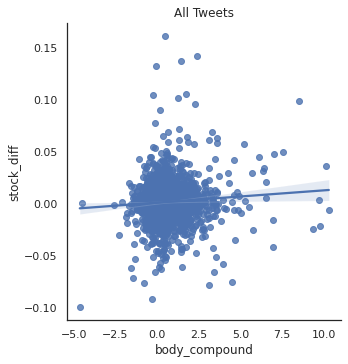

In [55]:
draw_lmplot(tweet_stock_diff_nonzero_df, 'body_compound', 'stock_diff', 'All Tweets')

##### Scatter Plot (Sector)

* All sectors on the same plot
* Each sector for one plot

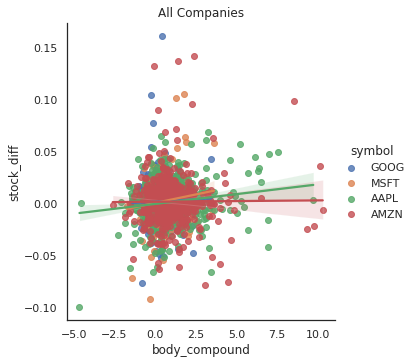

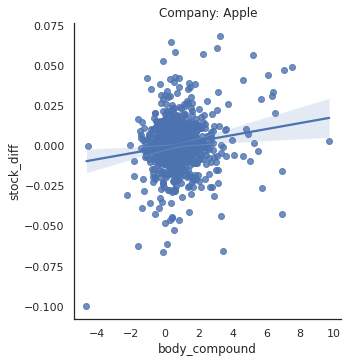

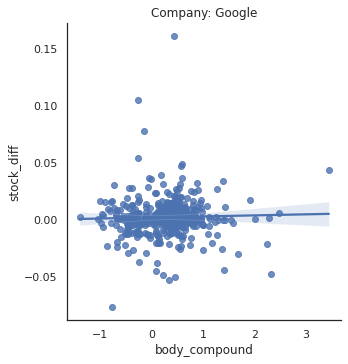

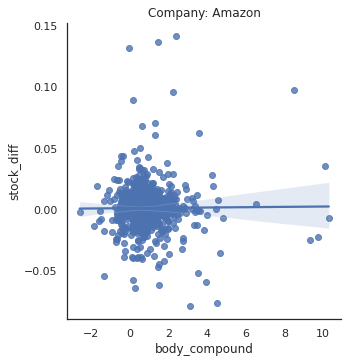

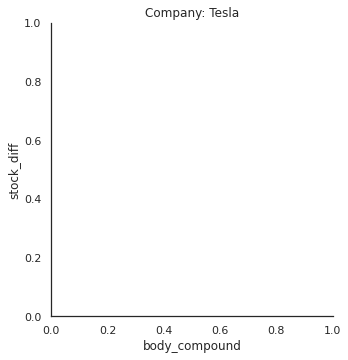

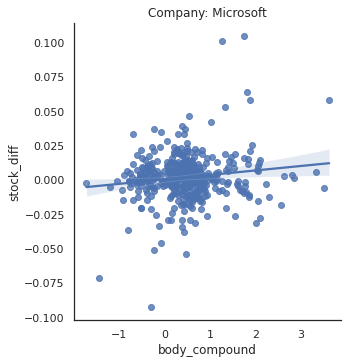

In [56]:
draw_lmplot(tweet_stock_diff_nonzero_df, 'body_compound', 'stock_diff', 'All Companies', hue='symbol')
for symbol in tweet_companies_symbol_list:
    title = 'Company: ' + tweet_company_symbol_dict[symbol]
    plot_company_df = tweet_stock_diff_nonzero_df[tweet_stock_diff_nonzero_df['symbol'] == symbol]
    draw_lmplot(plot_company_df, 'body_compound', 'stock_diff', title)

# Part 2: Financial data analysis

### 2.1 Process the Dataset
In this part, we will preparet all the dataframe needed for analysis or machine learning in the following session.

* Prepare the stock price data for future analysis.
* Create historical growth dataframe to analysis the performance of different companies
* Prepare the feature data for machine learning in part 3.

#### 2.1.1 Create stock price data
In this step, we created a dataframe of companies' historical stock prices in each year and quarter. This includes the following steps:

* Define a function for convert date to quarrter
* Create two columns of 'year' and 'month'
* Use the quarter() function to add a column of quarter
* Shard the dataset to get the average close price and average volume of each stock in each quarter

In [57]:
# Define a function for convert date to quarrter
def quarter(m):
  if 4 <= m <= 6:
    q = 1
  elif 7 <= m <= 9:
    q = 2
  elif 10 <= m <= 12:
    q = 3
  else:
    q = 4
  return q

In [58]:
# Change the data type of 'data' column to datatime type and drop all the rows with NaN
price_df['date']    = price_df['date'].astype('datetime64[ns]')
price_df            = price_df.dropna()

# Create two columns of 'year' and 'month' with the year and month of 'date' respectively
price_df['year']    = price_df['date'].dt.year
price_df['month']   = price_df['date'].dt.month

# Rename the 'symbol' column as 'stock'
price_df            = price_df.rename(columns={'symbol': 'stock'})

# Use the quarter() function to add a column of quarter
price_df['quarter'] = price_df['month'].apply(lambda x: quarter(x))

# Change the year number to year-1 if the quarter is 4 (eg. 2018 to 2017 if the quarter of that row is 4)
price_df['year']    = np.where(price_df['quarter'] == 4, price_df['year']-1, price_df['year'])

# Shard the dataset to get the average close price and average volume of each stock in each quarter 
q_price_df  = price_df[['stock', 'close', 'year', 'quarter']].groupby(['stock', 'year', 'quarter']).mean().reset_index()
q_volume_df = price_df[['stock', 'volume', 'year', 'quarter']].groupby(['stock', 'year', 'quarter']).mean().reset_index()
q_stock_df  = q_price_df.merge(q_volume_df, on=['stock', 'year', 'quarter'], how='outer')

# Round the price and volume to 1 decimal
q_stock_df['volume'] = q_stock_df['volume'].round(1)
q_stock_df['close']  = q_stock_df['close'].round(1)
q_stock_df

,stock,year,quarter,close,volume
0,A,1999,3,48.4,4105863.3
1,A,1999,4,93.7,1538461.9
2,A,2000,1,81.1,3786492.1
3,A,2000,2,54.6,3979341.3
4,A,2000,3,49.7,2822339.7
...,...,...,...,...,...
394810,ZYXI,2020,1,18.4,1016852.9
394811,ZYXI,2020,2,18.6,982741.0
394812,ZYXI,2020,3,14.3,649193.6
394813,ZYXI,2020,4,16.8,673857.3


#### 2.1.2 Feature data preparation and financial features analysis
In this part, we analyze the feature that will be used in the machine learning part.


In [59]:
# Choose to preserve 60000 samples for further analysis -> Tolerance is set to 0.8
tolerance                  = 0.8
filtered_column_feature_df = raw_feature_df.dropna(axis=1, thresh= int( len(raw_feature_df) * tolerance))
feature_data_sdf           = filtered_column_feature_df.dropna()

In [60]:
# Check data properties
print("Number of distince company:", len(pd.unique(feature_data_sdf['stock'])))
print("features available:", feature_data_sdf.columns)

# Drop the Unnamed:0 column
feature_data_sdf = feature_data_sdf.drop(labels='Unnamed: 0', axis=1)

# Set up date-time object
feature_data_sdf['filing_date'] = pd.to_datetime(feature_data_sdf['filing_date'], format='%Y-%m-%d')

# Separate out the months and years of our datav
feature_data_sdf['year']    = feature_data_sdf['filing_date'].apply(lambda x: x.year)
feature_data_sdf['month']   = feature_data_sdf['filing_date'].apply(lambda x: x.month)
feature_data_sdf['quarter'] = 1

feature_data_sdf['quarter'] = feature_data_sdf['month'].apply(lambda x: quarter(x))
feature_data_sdf['year']    = np.where(feature_data_sdf['quarter'] == 4, feature_data_sdf['year']-1, feature_data_sdf['year'])

feature_data_sdf = feature_data_sdf.rename(columns={'filing_date': 'date'})
temp             = feature_data_sdf.drop(labels=['date','stock','year','month','quarter'],axis=1)

Number of distince company: 2150
features available: Index(['Unnamed: 0', 'commonstocksharesissued', 'commonstockvalue',
       'liabilities', 'liabilitiesandstockholdersequity', 'stockholdersequity',
       'earningspersharebasic', 'netincomeloss', 'filing_date', 'stock'],
      dtype='object')


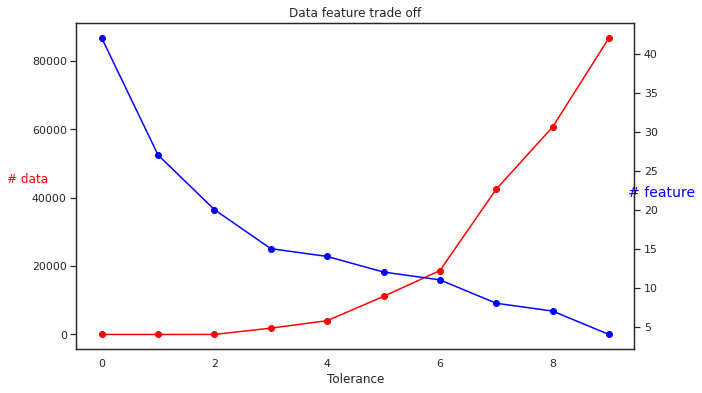

In [61]:
# Balancing the trade off of the data number and amount of features
import matplotlib.pyplot as plt
data_trade_off_curve     = []
feature_trade_off_curve  = []
for i in range(10):
  test  = raw_feature_df.dropna(axis=1, thresh=int(len(raw_feature_df)*(i / 10)))
  test1 = test.dropna()
  data_trade_off_curve.append(len(test1))
  feature_trade_off_curve.append(len(test1.columns)-3)

# Plotting function
fig,ax = plt.subplots(figsize=(10, 6))
# make a plot
ax.plot(range(len(data_trade_off_curve)), data_trade_off_curve, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Tolerance",fontsize=12)
# set y-axis label
ax.set_ylabel("# data",color="red",fontsize=12, rotation='horizontal')
# twin object for two different y-axis on the sample plot
ax2    = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(len(data_trade_off_curve)), feature_trade_off_curve, color="blue",marker="o")
ax2.set_ylabel("# feature",color="blue",fontsize=14, rotation='horizontal')
plt.title('Data feature trade off')
plt.show()


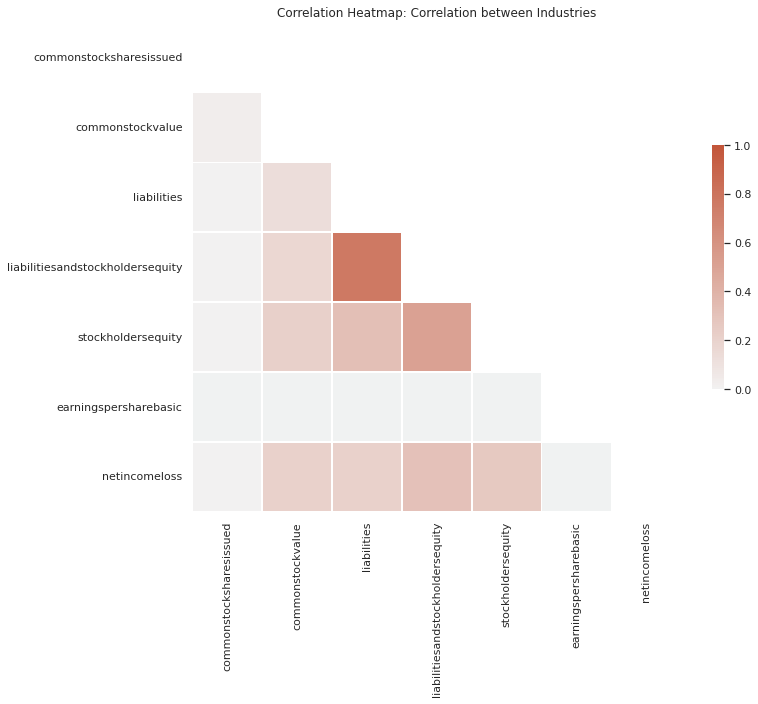

In [62]:
sns.set(style = "white")
# Compute the correlation matrix
# ASSIGN THE "corr" VARIABLE TO YOUR CORRELATION MATRIX
corr  = temp.corr()

# Generate a mask for the upper triangle
mask  = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap  = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Correlation between Industries")
plt.show()


In [63]:
# Merge two dataset
stock_financial = q_stock_df.merge(feature_data_sdf, on=['stock', 'year', 'quarter'], how='inner', indicator=True).rename(columns={'close': 'price'})
stock_financial = stock_financial.sort_values(by=['stock','year','quarter'], ascending=[True,True,True]).drop(['_merge'], axis=1).reset_index()
stock_financial

,index,stock,year,quarter,price,volume,commonstocksharesissued,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,date,month
0,0,A,2009,3,28.2,2781901.6,566000000.0,6000000.0,4.448000e+09,7.007000e+09,2.506000e+09,1.62,686000000.0,2009-12-21,12
1,1,A,2009,4,31.4,3616160.7,566000000.0,6000000.0,5.098000e+09,7.612000e+09,2.506000e+09,0.18,686000000.0,2010-03-10,3
2,2,A,2010,1,33.2,3777812.7,566000000.0,6000000.0,5.098000e+09,7.612000e+09,2.506000e+09,-0.11,121000000.0,2010-06-07,6
3,3,A,2010,3,36.5,3177423.4,566000000.0,6000000.0,5.098000e+09,7.612000e+09,2.506000e+09,1.91,121000000.0,2010-12-20,12
4,4,A,2010,4,43.2,3943188.7,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,0.23,121000000.0,2011-03-09,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58134,58134,ZUMZ,2018,3,21.2,505469.5,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.265830e+08,0.28,6865000.0,2018-12-10,12
58135,58135,ZUMZ,2018,4,23.7,479812.5,25249000.0,96468000.0,1.435950e+08,4.995100e+08,2.566140e+08,1.05,5000000.0,2019-03-18,3
58136,58136,ZUMZ,2019,1,24.3,400545.7,25521000.0,96468000.0,1.337340e+08,5.341900e+08,3.524850e+08,-0.10,-2607000.0,2019-06-10,6
58137,58137,ZUMZ,2019,2,26.4,466265.5,25521000.0,108360000.0,1.337340e+08,5.341900e+08,3.559150e+08,0.07,1770000.0,2019-09-09,9


## 2.2 Market trend Analysis: See the general growth trends and their correlation

#### 2.2.1 Growth of different industries
In this part, we analyzed the total market trend and development of different sectors. This includes the following steps:   


*   Create a dataframe of growth trends in different sector
*   Visualize the growth rate of each sector and the total market trend with line chart



First, create the dataframe of sector growth trend 

Steps:

*   Select the data from 2013 to 2019 since it covers most sectors
*   select the data of quarter 1 and let it represent sectors' situation in each year
*   Calculate the average stock price of each sector per year, based on the number of companies
*   Calculate the growth rate of each sector in each year compared with its price in 2013

In [64]:
stock_sector_df = stock_financial.merge(sector_relation_df, on=['stock'], how='left', indicator=True).dropna()
sector = list(stock_sector_df.Sector.unique())

# Count the numbers of companies in each sector and year
total_count = stock_sector_df[['stock', 'year', 'quarter']].loc[stock_sector_df['quarter'] == 1]
total_count = total_count.loc[total_count['year'] <= 2019].loc[total_count['year'] >= 2013]
total_count = total_count[['stock', 'year']].groupby(['year']).count().sort_values(by=['year'], ascending=True).reset_index()

total_growth = stock_sector_df[['year', 'price', 'quarter']].loc[stock_sector_df['quarter'] == 1]
total_growth = total_growth.loc[total_growth['year'] <= 2019].loc[total_growth['year'] >= 2013]
total_growth = total_growth[['year', 'price']].groupby(['year']).sum().sort_values(by=['year'], ascending=True).reset_index()

# Merge sum of price and number in each year
total_growth = total_growth.merge(total_count, on=['year'])
total_growth['price'] = (total_growth['price'] / total_growth['stock']).round(1)
total_growth = total_growth.drop(['stock'], axis=1).rename(columns={'price': 'Total'})


# Count the numbers of companies in each sector and year
company_count = stock_sector_df[['stock', 'year', 'quarter', 'Sector']].loc[stock_sector_df['quarter'] == 1]
company_count = company_count.loc[company_count['year'] <= 2019].loc[company_count['year'] >= 2013]
company_count = company_count[['stock', 'year', 'Sector']].groupby(['Sector','year']).count().sort_values(by=['Sector', 'year'], ascending=True).reset_index()

sector_growth = stock_sector_df[['year', 'price', 'quarter', 'Sector']].loc[stock_sector_df['quarter'] == 1]
sector_growth = sector_growth.loc[sector_growth['year'] <= 2019].loc[sector_growth['year'] >= 2013]
sector_growth = sector_growth[['year', 'price', 'Sector']].groupby(['Sector','year']).sum().sort_values(by=['Sector', 'year'], ascending=True).reset_index()

# Merge sum of price and number of companies
sector_growth = sector_growth.merge(company_count, on=['Sector', 'year'])
sector_growth['price'] = (sector_growth['price'] / sector_growth['stock']).round(1)

sector_growth = sector_growth.pivot(index='year', columns='Sector', values='price').round(1).reset_index()
sector_growth = sector_growth.merge(total_growth, on=['year']) # merge industry and total

# Calculate the growth rate of each sector in each year compared with its price in 2013
for i in range(1, len(sector_growth)): 
  sector_growth.iloc[i, 1:] = ((sector_growth.iloc[i, 1:] - sector_growth.iloc[0, 1:]) / sector_growth.iloc[0, 1:])

# Set the growth rate in 2013 equaling to 0
sector_growth.iloc[0, 1:] = 0



Visualize sector_growth

In [65]:
sector_growth

,year,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,Total
0,2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2014,0.223629,0.625954,0.140306,0.119266,0.251515,0.321799,0.243542,0.227425,-0.026393,0.128571,0.102857,0.195946
2,2015,0.202532,1.160305,0.298469,0.220183,-0.115152,0.179931,0.616236,0.250836,0.052786,0.314286,0.037143,0.250000
3,2016,0.113924,0.007634,0.102041,0.339450,-0.296970,0.179931,0.446494,0.193980,0.046921,0.319048,0.214286,0.175676
4,2017,0.320675,0.438931,0.344388,0.425076,-0.342424,0.318339,0.697417,0.357860,0.046921,0.571429,0.460000,0.337838
5,2018,0.523207,0.778626,0.563776,0.357798,-0.236364,0.698962,0.782288,1.140468,0.140762,1.247619,0.217143,0.672297
6,2019,0.253165,1.061069,0.566327,0.296636,-0.381818,0.474048,0.793358,1.173913,0.173021,0.733333,0.434286,0.574324


Second, visualize the growth rate of each sector and the total market trend with line chart

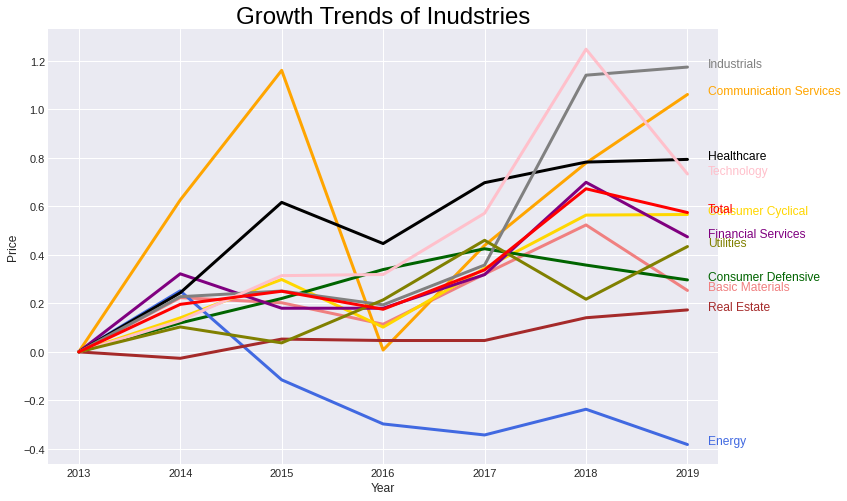

In [66]:
# Change the style of plot
plt.style.use('seaborn-darkgrid')

# set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# set color list
color = ['lightcoral', 'orange', 'gold', 'darkgreen', 'royalblue', 'purple', 'black', 'grey', 'brown', 'pink', 'olive', 'red']
 
# plot multiple lines
c = 0
for column in sector_growth.drop('year', axis=1):
    plt.plot(sector_growth['year'], sector_growth[column], marker='', color=color[c], linewidth=3, alpha=1.0)
    c += 1

# annotate the plot
num=0
c = 0
for i in sector_growth.values[6][1:]:
    num+=1
    name=list(sector_growth)[num]
    plt.text(2019.2, i, name, horizontalalignment='left', size='medium', color=color[c])
    c += 1

# Add titles
plt.title("Growth Trends of Inudstries", loc='center', fontsize=24, fontweight=0, color='Black')
plt.xlabel("Year")
plt.ylabel("Price")

# Show the graph
plt.show()

Conclusions on sector growth:

*   The overall market growth rate is relatively stable, and the growth rate is relatively large from 2016 to 2018.
*   Healthcare, Technology, Industrials and Communication Services growth rates exceed the market from 2017 to 2019. Among them, the stock price of Healthcare sector volates greatly.
*   Real estate and Energy growth rates are lower than market levels. The overall stock price of Energy is on a downward trend.
*   The situation of the financial industry can basically reflect the overall situation of the market.


#### 2.2.2 Correlation between different industries
In this part, we analyze the correlation of growth trend between different industries.


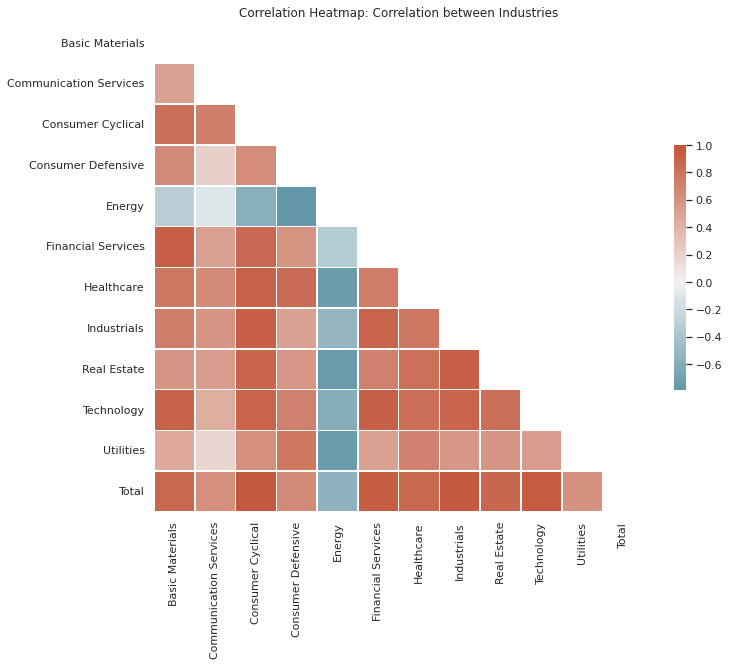

In [67]:
# impact_df = sector_growth[['Basic Materials',	'Consumer Cyclical',	'Consumer Defensive',	'Energy',	'Healthcare',	'Industrials',	'Real Estate',	'Technology']]
impact_df = sector_growth.drop(labels=['year'],axis=1)

sns.set(style = "white")

# Compute the correlation matrix
# ASSIGN THE "corr" VARIABLE TO YOUR CORRELATION MATRIX
corr = impact_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap  = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Correlation between Industries")
plt.show()

### 2.2.3 Company Analysis: separate them into differnet level for further analysis

In this part, we analyzed the performance of company in term of their growing rate in stock prices.

*   Calculate the growth rate of each company using stock price data
*   Divide the average growth rate into four group: High rising, Medium rising, Medium falling, High falling.
*   Plot the histogram of the result.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


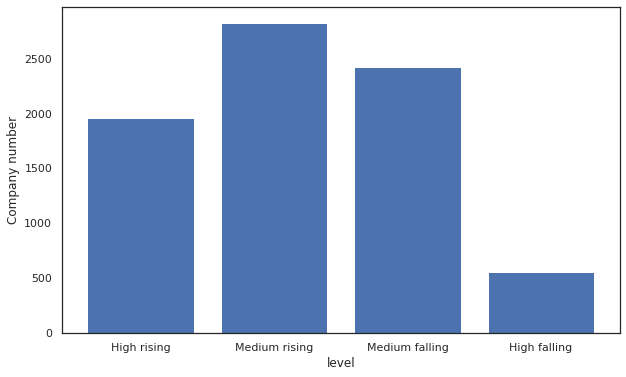

In [68]:
# Split the company into four level according to their stock price change
# The four levels are correspondingly: High rising, Medium rising, Medium falling, High falling

# Create data frame with company, year, and stock price
stock         = q_stock_df.groupby(by=['stock','year']).mean().reset_index()[['stock','year','close']].reset_index()

# Prepare data frame for join to calculate the stock price chang on the following year
temp          = stock.copy()
temp['index'] = temp['index'] - 1

# Merge according to the sorted index and filter out the data with not match company
temp2         = stock.merge(right = temp, on='index')
temp2['zero'] = temp2.apply(lambda x: x.stock_x == x.stock_y, axis=1)
temp2         = temp2[temp2['zero']]
temp3         = temp2[['stock_x', 'year_x', 'close_x', 'close_y']]

# Calculate the stock price change
temp3['price_change_percentage'] = (temp3['close_x'].copy() - temp3['close_y'].copy()) / temp3['close_y'].copy()

# Clean up the data
temp3         = temp3.dropna()

# Calculate the average stock price change
temp4         = temp3.groupby(by=['stock_x','year_x']).mean()
temp5         = temp4.reset_index().groupby('stock_x').mean().reset_index()
temp5         = temp5[['stock_x','price_change_percentage']]

# Identify the company with different stock price change levels
high = 0.15
low  = 0.15

# Rising
high_rising    = temp5[temp5['price_change_percentage'] > high]
medium_rising  = temp5[temp5['price_change_percentage'] < high]
medium_rising  = medium_rising[medium_rising['price_change_percentage'] > 0.]
# Falling
high_falling   = temp5[temp5['price_change_percentage'] < -low]
medium_falling = temp5[temp5['price_change_percentage'] > -low]
medium_falling = medium_falling[medium_falling['price_change_percentage'] < 0.]
# High changing company
temp6          = temp4.reset_index().groupby('stock_x').std()
temp7          = temp6['price_change_percentage'].mean()
high_varing_company = temp6[temp6['price_change_percentage'] > temp7]

# Total analysis:
high_rising_n     = high_rising.count()['price_change_percentage']
medium_rising_n   = medium_rising.count()['price_change_percentage']
high_falling_n    = high_falling.count()['price_change_percentage']
medium_falling_n  = medium_falling.count()['price_change_percentage']

# Plotting the distribution
height = [high_rising_n, medium_rising_n, medium_falling_n, high_falling_n]
bars   = ['High rising', 'Medium rising', 'Medium falling', 'High falling']
y_pos  = np.arange(len(bars))
# Create bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bars, height)
plt.xlabel('level')
plt.ylabel('Company number')
# Show graphick
plt.show()

# Part 3: Machine learning

### 3.1 Machine Learning: Preprocessing data

1. Incorporate the data from stock_financial data frame.
2. Incorporate the change in stock price and label the data according to it.


In [69]:
# Prepare data frame for join to calculate the stock price chang on the following year .drop(labels=['index',	'year',	'quarter', 'date', 'month'], axis=1)
temp            = stock_financial[['stock',	'year',	'quarter', 'price']].copy()
temp['quarter'] = temp['quarter'] - 1
# temp            = stock_financial.copy().drop(labels=['index', 'date', 'month'], axis=1)


temp_temp                 = stock_financial.copy().drop(labels=['index', 'date', 'month'], axis=1)
temp_temp['quarter']      = temp_temp['quarter'] + 1
temp3                     = stock_financial.merge(right= temp_temp, on=['stock',	'year',	'quarter']) 
temp3                     = temp3.rename(columns={'price_x':'price'})
temp3['price_c']          = temp3['price'] - temp3['price_y']
temp3['volum_c']          = temp3['volume_x'] - temp3['volume_y'] 
temp3['commonstocksharesissued_c'] = temp3['commonstocksharesissued_x'] - temp3['commonstocksharesissued_y']
temp3['commonstockvalue_c']        = temp3['commonstockvalue_x'] - temp3['commonstockvalue_y']
temp3['liabilities_c']             = temp3['liabilities_x'] - temp3['liabilities_y']
temp3['netincomeloss_c']           = temp3['netincomeloss_x'] - temp3['netincomeloss_y']
temp3                              = temp3.drop(labels=['index', 'date', 'month'], axis=1)

# # Merge according to the sorted index and filter out the data with not match company
temp2           = stock_financial.merge(right = temp, on=['stock',	'year',	'quarter'])
temp2['label']  = (temp2['price_y'] - temp2['price_x'] ) / temp2['price_x']
temp2['label']  = temp2['label'].apply(lambda x: 1 if x > 0 else 0)
temp2           = temp2.drop(labels='price_y',axis=1)
temp2           = temp2.rename(columns={'price_x':'price'})
temp2           = temp2.merge(right = temp3, on=['stock',	'year',	'quarter'])
temp2
data            = temp2.drop(labels=['index',	'year', 'date', 'month'], axis=1)
data_label      = temp2['label']
data            = data.drop(labels='label',axis=1)
data

,stock,quarter,price_x,volume,commonstocksharesissued,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,price_y,volume_x,commonstocksharesissued_x,commonstockvalue_x,liabilities_x,liabilitiesandstockholdersequity_x,stockholdersequity_x,earningspersharebasic_x,netincomeloss_x,price_y,volume_y,commonstocksharesissued_y,commonstockvalue_y,liabilities_y,liabilitiesandstockholdersequity_y,stockholdersequity_y,earningspersharebasic_y,netincomeloss_y,price_c,volum_c,commonstocksharesissued_c,commonstockvalue_c,liabilities_c,netincomeloss_c
0,A,2,38.6,5616417.2,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,1.13,121000000.0,38.6,5616417.2,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,1.13,121000000.0,48.6,3501258.7,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,0.54,121000000.0,-10.0,2115158.5,0.0,0.0,0.0,0.0
1,A,3,35.2,4253146.0,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,-0.09,121000000.0,35.2,4253146.0,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,-0.09,121000000.0,38.6,5616417.2,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,1.13,121000000.0,-3.4,-1363271.2,0.0,0.0,0.0,0.0
2,A,2,38.2,3257481.0,591000000.0,6000000.0,4.884000e+09,9.757000e+09,4.870000e+09,2.08,121000000.0,38.2,3257481.0,591000000.0,6000000.0,4.884000e+09,9.757000e+09,4.870000e+09,2.08,121000000.0,40.8,3173309.5,591000000.0,6000000.0,4.741000e+09,9.057000e+09,4.308000e+09,1.13,121000000.0,-2.6,84171.5,0.0,0.0,143000000.0,0.0
3,A,3,38.1,3593867.7,591000000.0,6000000.0,5.351000e+09,1.053600e+10,4.308000e+09,1.97,121000000.0,38.1,3593867.7,591000000.0,6000000.0,5.351000e+09,1.053600e+10,4.308000e+09,1.97,121000000.0,38.2,3257481.0,591000000.0,6000000.0,4.884000e+09,9.757000e+09,4.870000e+09,2.08,121000000.0,-0.1,336386.7,0.0,0.0,467000000.0,0.0
4,A,2,47.1,2627009.4,602000000.0,6000000.0,5.351000e+09,1.027800e+10,5.182000e+09,0.70,168000000.0,47.1,2627009.4,602000000.0,6000000.0,5.351000e+09,1.027800e+10,5.182000e+09,0.70,168000000.0,43.4,3825393.8,602000000.0,6000000.0,5.351000e+09,1.058700e+10,5.182000e+09,1.00,168000000.0,3.7,-1198384.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25606,ZUMZ,2,22.8,561084.6,27377000.0,132379000.0,1.522370e+08,4.573550e+08,4.710000e+06,0.11,3213000.0,22.8,561084.6,27377000.0,132379000.0,1.522370e+08,4.573550e+08,4.710000e+06,0.11,3213000.0,30.7,462398.7,29535000.0,131715000.0,1.411210e+08,5.055470e+08,1.149830e+08,0.10,2770000.0,-7.9,98685.9,-2158000.0,664000.0,11116000.0,443000.0
25607,ZUMZ,3,16.2,498041.5,26683000.0,133803000.0,1.415400e+08,4.410700e+08,4.710000e+06,0.36,9653000.0,16.2,498041.5,26683000.0,133803000.0,1.415400e+08,4.410700e+08,4.710000e+06,0.36,9653000.0,22.8,561084.6,27377000.0,132379000.0,1.522370e+08,4.573550e+08,4.710000e+06,0.11,3213000.0,-6.6,-63043.1,-694000.0,1424000.0,-10697000.0,6440000.0
25608,ZUMZ,2,26.2,458538.1,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.145050e+08,-0.21,-5056000.0,26.2,458538.1,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.145050e+08,-0.21,-5056000.0,24.9,443137.2,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.055690e+08,-0.18,-4448000.0,1.3,15400.9,0.0,0.0,0.0,-608000.0
25609,ZUMZ,3,21.2,505469.5,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.265830e+08,0.28,6865000.0,21.2,505469.5,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.265830e+08,0.28,6865000.0,26.2,458538.1,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.145050e+08,-0.21,-5056000.0,-5.0,46931.4,0.0,0.0,0.0,11921000.0


### 3.2 Machine Learning: different models

We use the following model to fit on our training data, and use the test set to check whether the model is performing well.

1. SVM
2. Random forest model
3. Logistic regression model

#### 3.2.1 Machine Learning: SVM

**Data preparation**
* Scale the data using standard scalar in scikit learn module.

**Training and testing**
* Use Supprot vector machine with rbf kernel to fit the training data
* Show the result of fitting

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=0.3, random_state=42)
scalar  = StandardScaler()
scalar.fit(x_train.drop(labels='stock', axis=1))

x_train_scaled = scalar.transform(x_train.drop(labels='stock', axis=1))
x_test_scaled  = scalar.transform(x_test.drop(labels='stock', axis=1))

classifier     = svm.SVC(C = 1, gamma='auto', kernel='rbf')#class_weight = 'balanced' ,kernel='poly', degree=5
classifier.fit(x_train_scaled, y_train)

print("Training accuracy is:", classifier.score(x_train_scaled, y_train))
print('Testing accuracy is:',  classifier.score(x_test_scaled, y_test))

Training accuracy is: 0.6042282590505941
Testing accuracy is: 0.5923997917751171


#### 3.2.2 Machine Learning: Random Forest

**Data preparation**
* Scale the data using standard scalar in scikit learn module.

**Training and testing**
* Use random foreset with 100 estimators
* Show the result of fitting

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn

x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=0.3, random_state=42)
x_test  = x_test.drop(labels='stock', axis=1)
x_train = x_train.drop(labels='stock', axis=1)

rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=10, min_samples_split=20)
rf.fit(x_train, y_train)

test_accuracy  = rf.score(x_test, y_test) 
train_accuracy = rf.score(x_train, y_train)
print('Training accuracy is:',  train_accuracy)
print('Testing accuracy is:',  test_accuracy)

Training accuracy is: 0.859206783064651
Testing accuracy is: 0.6212909942738157


#### 3.2.3 Machine Learning: Logistic Regression

**Data preparation**
* Prepare the data with changing trends inside.
* Split the data into trianing and testing group.
* Scale the data using standard scalar in scikit learn module.

**Training and testing**
* Use logistic Regression with 5 cross validation
* Show the result of fitting

In [72]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=0.3, random_state=42)
scalar  = StandardScaler()
scalar.fit(x_train.drop(labels='stock', axis=1))

x_train_scaled = scalar.transform(x_train.drop(labels='stock', axis=1))
x_test_scaled  = scalar.transform(x_test.drop(labels='stock', axis=1))

clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(x_train_scaled, y_train)
train_accuracy  = clf.score(x_train_scaled, y_train)
test_accuracy = clf.score(x_test_scaled, y_test)

print('Training accuracy is:',  train_accuracy)
print('Testing accuracy is:',  test_accuracy)

Training accuracy is: 0.5603279968762203
Testing accuracy is: 0.5646798542425819


#### 3.2.4 Machine Learning: conclusion

1. We can see that the performance of different models in this data is just slightly better than gaussing.
2. We can also find that it is also hard even for the model to overfit the data even if we use many features for fitting, which might indicate that the features is not relevent to the labels.


### 3.3 Machine Learning: Include compound score in text analysis

***Step:***
1. Incorporate the data from stock_financial data frame.
2. Incorporate the change in stock price and label the data according to it.
3. Further add in the compound score we have in the sentimental analysis to see if we can improve the accuracy.

In [73]:
temp            = stock_financial[['stock',	'year',	'quarter', 'price']].copy()
temp['quarter'] = temp['quarter'] - 1
temp_temp                 = stock_financial.copy().drop(labels=['index', 'date', 'month'], axis=1)
temp_temp['quarter']      = temp_temp['quarter'] + 1
temp3                     = stock_financial.merge(right= temp_temp, on=['stock',	'year',	'quarter']) 
temp3                     = temp3.rename(columns={'price_x':'price'})
temp3['price_c']          = temp3['price'] - temp3['price_y']
temp3['volum_c']          = temp3['volume_x'] - temp3['volume_y'] 
temp3['commonstocksharesissued_c'] = temp3['commonstocksharesissued_x'] - temp3['commonstocksharesissued_y']
temp3['commonstockvalue_c']        = temp3['commonstockvalue_x'] - temp3['commonstockvalue_y']
temp3['liabilities_c']             = temp3['liabilities_x'] - temp3['liabilities_y']
temp3['netincomeloss_c']           = temp3['netincomeloss_x'] - temp3['netincomeloss_y']
temp3                              = temp3.drop(labels=['index', 'date', 'month'], axis=1)

# # Merge according to the sorted index and filter out the data with not match company
temp2           = stock_financial.merge(right = temp, on=['stock',	'year',	'quarter'])
temp2['label']  = (temp2['price_y'] - temp2['price_x'] ) / temp2['price_x']
temp2['label']  = temp2['label'].apply(lambda x: 1 if x > 0 else 0)
temp2           = temp2.drop(labels='price_y',axis=1)
temp2           = temp2.rename(columns={'price_x':'price'})
temp2           = temp2.merge(right = temp3, on=['stock',	'year',	'quarter'])

compound_score_ml_df = compound_score_ml_df.rename(columns={'symbol':'stock'})

temp2           = temp2.merge(right = compound_score_ml_df, how='left', on=['stock',	'year',	'quarter']).fillna(0)
data            = temp2.drop(labels=['index',	'year', 'date', 'month'], axis=1)
data_label      = temp2['label']
data            = data.drop(labels='label',axis=1)
data


,stock,quarter,price_x,volume,commonstocksharesissued,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,price_y,volume_x,commonstocksharesissued_x,commonstockvalue_x,liabilities_x,liabilitiesandstockholdersequity_x,stockholdersequity_x,earningspersharebasic_x,netincomeloss_x,price_y,volume_y,commonstocksharesissued_y,commonstockvalue_y,liabilities_y,liabilitiesandstockholdersequity_y,stockholdersequity_y,earningspersharebasic_y,netincomeloss_y,price_c,volum_c,commonstocksharesissued_c,commonstockvalue_c,liabilities_c,netincomeloss_c,headline_compound,body_compound
0,A,2,38.6,5616417.2,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,1.13,121000000.0,38.6,5616417.2,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,1.13,121000000.0,48.6,3501258.7,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,0.54,121000000.0,-10.0,2115158.5,0.0,0.0,0.0,0.0,0.0,0.0
1,A,3,35.2,4253146.0,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,-0.09,121000000.0,35.2,4253146.0,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,-0.09,121000000.0,38.6,5616417.2,579000000.0,6000000.0,6.460000e+09,9.696000e+09,3.228000e+09,1.13,121000000.0,-3.4,-1363271.2,0.0,0.0,0.0,0.0,0.0,0.0
2,A,2,38.2,3257481.0,591000000.0,6000000.0,4.884000e+09,9.757000e+09,4.870000e+09,2.08,121000000.0,38.2,3257481.0,591000000.0,6000000.0,4.884000e+09,9.757000e+09,4.870000e+09,2.08,121000000.0,40.8,3173309.5,591000000.0,6000000.0,4.741000e+09,9.057000e+09,4.308000e+09,1.13,121000000.0,-2.6,84171.5,0.0,0.0,143000000.0,0.0,0.0,0.0
3,A,3,38.1,3593867.7,591000000.0,6000000.0,5.351000e+09,1.053600e+10,4.308000e+09,1.97,121000000.0,38.1,3593867.7,591000000.0,6000000.0,5.351000e+09,1.053600e+10,4.308000e+09,1.97,121000000.0,38.2,3257481.0,591000000.0,6000000.0,4.884000e+09,9.757000e+09,4.870000e+09,2.08,121000000.0,-0.1,336386.7,0.0,0.0,467000000.0,0.0,0.0,0.0
4,A,2,47.1,2627009.4,602000000.0,6000000.0,5.351000e+09,1.027800e+10,5.182000e+09,0.70,168000000.0,47.1,2627009.4,602000000.0,6000000.0,5.351000e+09,1.027800e+10,5.182000e+09,0.70,168000000.0,43.4,3825393.8,602000000.0,6000000.0,5.351000e+09,1.058700e+10,5.182000e+09,1.00,168000000.0,3.7,-1198384.4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25606,ZUMZ,2,22.8,561084.6,27377000.0,132379000.0,1.522370e+08,4.573550e+08,4.710000e+06,0.11,3213000.0,22.8,561084.6,27377000.0,132379000.0,1.522370e+08,4.573550e+08,4.710000e+06,0.11,3213000.0,30.7,462398.7,29535000.0,131715000.0,1.411210e+08,5.055470e+08,1.149830e+08,0.10,2770000.0,-7.9,98685.9,-2158000.0,664000.0,11116000.0,443000.0,0.0,0.0
25607,ZUMZ,3,16.2,498041.5,26683000.0,133803000.0,1.415400e+08,4.410700e+08,4.710000e+06,0.36,9653000.0,16.2,498041.5,26683000.0,133803000.0,1.415400e+08,4.410700e+08,4.710000e+06,0.36,9653000.0,22.8,561084.6,27377000.0,132379000.0,1.522370e+08,4.573550e+08,4.710000e+06,0.11,3213000.0,-6.6,-63043.1,-694000.0,1424000.0,-10697000.0,6440000.0,0.0,0.0
25608,ZUMZ,2,26.2,458538.1,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.145050e+08,-0.21,-5056000.0,26.2,458538.1,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.145050e+08,-0.21,-5056000.0,24.9,443137.2,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.055690e+08,-0.18,-4448000.0,1.3,15400.9,0.0,0.0,0.0,-608000.0,0.0,0.0
25609,ZUMZ,3,21.2,505469.5,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.265830e+08,0.28,6865000.0,21.2,505469.5,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.265830e+08,0.28,6865000.0,26.2,458538.1,25249000.0,96468000.0,1.435950e+08,4.995100e+08,3.145050e+08,-0.21,-5056000.0,-5.0,46931.4,0.0,0.0,0.0,11921000.0,0.0,0.0


#### 3.3.1 Machine Learning: SVM Revisit

**Data preparation**
* Scale the data using standard scalar in scikit learn module.

**Training and testing**
* Use Supprot vector machine with rbf kernel to fit the training data
* Show the result of fitting

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=0.3, random_state=42)
scalar  = StandardScaler()
scalar.fit(x_train.drop(labels='stock', axis=1))

x_train_scaled = scalar.transform(x_train.drop(labels='stock', axis=1))
x_test_scaled  = scalar.transform(x_test.drop(labels='stock', axis=1))

classifier     = svm.SVC(C = 1, gamma='auto', kernel='rbf')#class_weight = 'balanced' ,kernel='poly', degree=5
classifier.fit(x_train_scaled, y_train)

print("Training accuracy is:", classifier.score(x_train_scaled, y_train))
print('Testing accuracy is:',  classifier.score(x_test_scaled, y_test))

Training accuracy is: 0.6053996764656663
Testing accuracy is: 0.594742321707444


#### 3.3.2 Machine Learning: Random Forest revisit

**Data preparation**
* Scale the data using standard scalar in scikit learn module.

**Training and testing**
* Use random foreset with 100 estimators
* Show the result of fitting

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn

x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=0.3, random_state=42)
x_test  = x_test.drop(labels='stock', axis=1)
x_train = x_train.drop(labels='stock', axis=1)

rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=10, min_samples_split=20)
rf.fit(x_train, y_train)

test_accuracy  = rf.score(x_test, y_test) 
train_accuracy = rf.score(x_train, y_train)
print('Training accuracy is:',  train_accuracy)
print('Testing accuracy is:',  test_accuracy)

Training accuracy is: 0.8635019802532493
Testing accuracy is: 0.6192087454450806


#### 3.3.3 Machine Learning: Logistic Regression revisit

**Data preparation**
* Prepare the data with changing trends inside.
* Split the data into trianing and testing group.
* Scale the data using standard scalar in scikit learn module.

**Training and testing**
* Use logistic Regression with 5 cross validation
* Show the result of fitting

In [76]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=0.3, random_state=42)
scalar  = StandardScaler()
scalar.fit(x_train.drop(labels='stock', axis=1))

x_train_scaled = scalar.transform(x_train.drop(labels='stock', axis=1))
x_test_scaled  = scalar.transform(x_test.drop(labels='stock', axis=1))

clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(x_train_scaled, y_train)
train_accuracy  = clf.score(x_train_scaled, y_train)
test_accuracy = clf.score(x_test_scaled, y_test)

print('Training accuracy is:',  train_accuracy)
print('Testing accuracy is:',  test_accuracy)

Training accuracy is: 0.5606626875662408
Testing accuracy is: 0.5642894325871942


#### 3.3.4 Machine Learning: conclusion

1. Based on our result, we find that including compound score into features can only leads to marginal imporvement (0.2%), and this seem reasonable since we cannot find strong correlation between compound score and stock price in the previous analysis.
2. One way for further improvement maybe to have a model that can capture a more complex concepts in language model, and use that features from the model to predict stock price.

# Part 4: Conclusion, Challenge and Improvement

### 4.1 Text Analysis

#### 4.1.1 Conclusion

* Daily stock price movement are irrelevant to news headline
* Daily stock price movement are irrelevant to tweet comments (for top tech companies)
* Tweet can show what public thinks of a specific company and we can use big data analytics to capture the trend
* The number of News related to companies are far less than tweet since news are selected and often has their own preference (e.g. politics). Therefore, there might be some bias with the word frequencies and compound scores

#### 4.1.2 Challenge

* The selected news dataset might has bias
* In news dataset, the rows might not related to the company name (i.e. companies related to social media)
* The number of rows about filtered compound score dataset are not enough

#### 4.1.3 Improvement

* Choose dataset from various media companies or merge several datasets
* Find larger news dataset
* To speed up sentiment analysis (spend 20 minutes), we can train the NLP model by ourselves instead of using public library
* Use aggregration in stock price movement (i.e. daily to weekly) to remove the high-frequency trend
* Consider tweet importance factor by adding weighting factor (the number of like, retweet) to tweet compound score

### 4.2 Fianancial data Analysis

#### 4.2.1 Conclusion
* The data set we use exist large features and data amount trade off. To get more features, we need to sacrifice a lot of data.
* We can see in the analysis that the feature do not exist strong correlation between each other whcih is suitable for machine learning.

#### 4.2.2 Challenge

* In this kind of prediction tesk, there exist data imbalance issue since that the overall growth of stock prices is positive statistically.
* Even if we have large amount of features for machine learning technics, the features may not be good indicators for storck price. The may not exist a mapping function between these features and the labels.

#### 4.2.3 Improvement

* Identify better features for learning.
* We can add in statistical features like mean or variance for future machine learning technics which may improve the accuracy of prediction.

### 4.3 Machine learning

#### 4.3.1 Conclusion
* The overall performance for differnet models is better than gaussing but not enough for practical usage.
* Hard to even overfit to the data, and this might indicate that the features are not useful for prediction.

| | Support Vector Machine | Random Forest | Logistic Regression |
|-|:-:|:-:|:-:|
|Without Text Data| 0.5923 | 0.6225 | 0.5647 |
|With Text Data| 0.5947 | 0.6264 | 0.5643 |

#### 4.3.2 Challenge

* Amount of data may not be enough for model to learn complex concept behind the prediction of stock prices.
* We might need to incorporate more features and test if they are suitable for differnet kind of machine learning models.
* Stock price data exist high frequence change, and the data distribution also change with time, it might be hard to capture the concept behind in seasonal period.

#### 4.3.3 Improvement

* Utilize more suitable model like ARIMA which is designed for the forecasting.
* This problem may require model with much larger capacity to capture the fast changing stock prices.